In [85]:
from src.crawler.base_crawler import BaseCrawler
from bs4 import BeautifulSoup
import pandas as pd
from pprint import pprint
import re
import json
import os
from Feature_crawler import Feature_Crawler
from Tsv_crawler import Tsv_Crawler
from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor,Grayscale
import numpy as np

学習用のデータの取り出し方を指定する

In [86]:
def one_to_three(img):
    if len(img.size)==2:
        transform=Grayscale(num_output_channels=3)
        return transform(img)
    else:
        return img

tsvデータと画像等のデータをくっつけて交差検証用にデータ分割する

In [92]:

class integrator():
    def __init__(self,last,n_splits=5,shuffle=True):
        self.fea=Feature_Crawler(last)
        self.tsv=Tsv_Crawler(last)
        self.full=self.tsv.title.join(self.fea.feature,how="outer")
        self.elminate_non_image()
        
        self._full = self.set_push_data(self.full)
        
        
        self.splitter = KFold(n_splits=n_splits, shuffle=shuffle)
        self.split_full=[[self.set_push_data(self.full.iloc[train]), self.set_push_data(self.full.iloc[test])]for train,test in self.splitter.split(self.full)]
        
    def elminate_non_image(self):
        self.full=self.full.dropna(subset=["image_exist"])
        
    def set_push_data(self,panda):
        class push_data():
            def __init__(self,panda=panda, title_size=False):
                self.full=panda
                self.title_size=title_size
                self.full_title=list(self.full.index)
                self.image_loader=Feature_Crawler(light=True).load_image

            def __len__(self):
                return len(self.full)

            def __getitem__(self,idx):
                transform = transforms.Compose(
                    [
                        transforms.Lambda(one_to_three),
                        transforms.Resize([300,256]),
                        transforms.ToTensor()
                    ]
                )
                poster=transform(self.image_loader(self.full_title[idx]))
                    
                if self.title_size:
                    #他のデータも(ex　title,size)
                    return poster, self.full_title[idx],self.image_loader(self.full_title[idx]).size
                
                return poster
                
        return push_data
            


In [93]:
s=integrator(last)


使用例

In [94]:
last=200

In [95]:
import itertools as it
import matplotlib.pyplot as plt

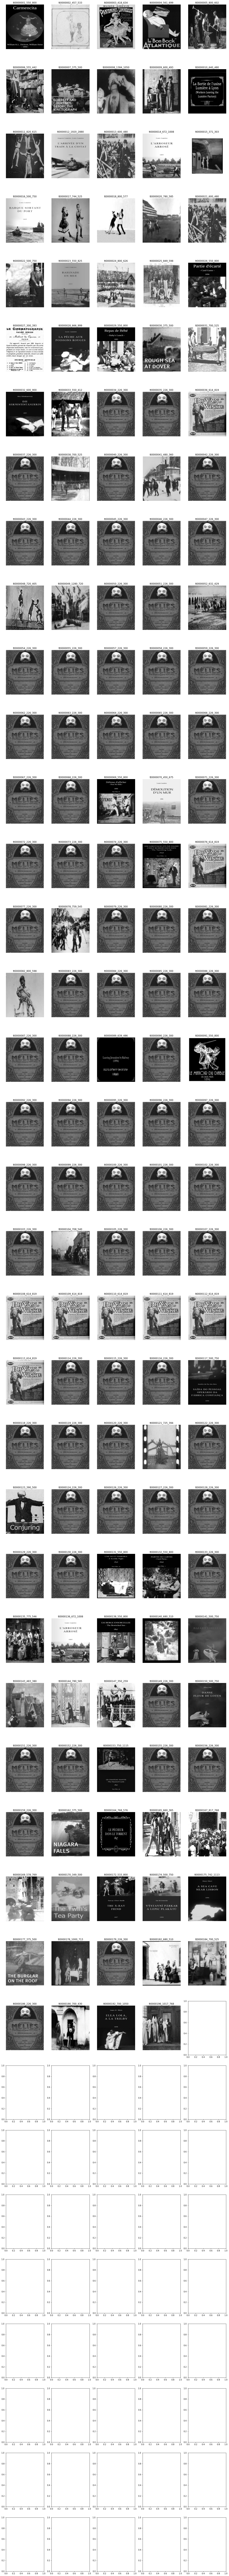

In [96]:
trainset = integrator(last).split_full[0][0](title_size=True)
testset = integrator(last).split_full[0][1](title_size=True)
fullset = integrator(last)._full(title_size=True)
train_loader=DataLoader(trainset,batch_size=5)
#学習用

ncols = 5
nrows = last//ncols
fig, axes = plt.subplots(nrows,ncols,figsize=(20,6*nrows))
b=0
for ax,(im,ti,si) in zip(axes.flat, fullset):
    ax.imshow(im.transpose(0,1).transpose(1,2))
    ax.set_title(ti+"_"+str(si[0])+"_"+str(si[1]))
    ax.axis('off')

tt0000001
